# Exploring the data file

MaNGA DR15

In [4]:
# Import main libraries
%matplotlib inline
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = 'stix'
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
from astropy.table import Table

# Some useful functions for calculations/plots
from natastro import utils
import natastro.plotutils as nplot
from natastro.labels import get_labels

---
## 1. Reading the data

In [5]:
# Local dir
table_file = 'example_data/SIGNALS_table_spaxels_8247-12704.hdf5'

# Read spaxels table
ts = Table.read(table_file, path='/spaxel')

# Read integrated table
ti = Table.read(table_file, path='/integrated')

---
## 2. Drivers -- skip this for now, simply run it

In [6]:
# Drivers to transform tables into 2D matrices and plot them. Please feel free to skip reading.

def get_map(label, flag_sp=None, extratop=0, extrabottom=0, extraright=0, extraleft=0,):
    if flag_sp is None:
        flag_sp = np.ones(len(ts), 'bool')
    y = ts[flag_sp]['y']
    x = ts[flag_sp]['x']
    y = y - np.min(y) + extrabottom
    x = x - np.min(x) + extraright
    Ny = np.max(y) + 1 + extratop
    Nx = np.max(x) + 1 + extraleft

    # Make a square and center map
    N = np.max([Nx, Ny])
    Ny, Nx = N, N
    if (np.max(x) > np.max(y)):
        dy = ((Ny - 1) - y.max())/2
        y += int(dy)
    else:
        dx = ((Nx - 1) - x.max())/2
        x += int(dx)

    #print('Size: ', Nx*ts[flag_sp]['pixel_scale_pc'][0])
    map__yx = np.full((Ny, Nx), np.nan)
    map__yx[y, x] = ts[flag_sp][label]
    map__yx = utils.mask_minus999(map__yx)
    return map__yx


def plot_map_manga(ax, var, vmin = None, vmax = None, cmap='inferno_r', title=False, label=True, cb=False, cb_top=False, cb_bottom=False, **kwargs):
    im = ax.imshow(get_map(var, **kwargs), origin = 'lower', vmin = vmin, vmax = vmax, cmap=cmap)
    im.set_rasterized(True)
    if (title) & (label):
        plt.title(nplot.label(var, labels))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for spine in ax.spines.values():
        spine.set_color('grey')
        spine.set_alpha(0.2)
    
    if cb:
        cb = nplot.tight_colorbar(im)
        nplot.fix_colorbar_ticks(cb)
        if (not title) & (label):
            cb.set_label(nplot.label(var, labels), rotation=-90, labelpad=15)
            
    if cb_top:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cax = inset_axes(ax,
                        width="100%",  # width = 50% of parent_bbox width
                        height="10%",  # height : 5%
                        bbox_to_anchor=(0., 0.6, 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0,
                        loc='center')
        cb = plt.colorbar(im, cax=cax, orientation='horizontal')
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')
        nplot.fix_colorbar_ticks(cb)
        if label:
            cb.set_label(nplot.label(var, labels))

    if cb_bottom:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cax = inset_axes(ax,
                        width="100%",  # width = 50% of parent_bbox width
                        height="10%",  # height : 5%
                        bbox_to_anchor=(0., -0.6, 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0,
                        loc='center')
        cb = plt.colorbar(im, cax=cax, orientation='horizontal')
        nplot.fix_colorbar_ticks(cb, ny=2)
        if label:
            cb.set_label(nplot.label(var, labels))
            
def mask_minus999(var, thereshold = -990., fill = None):
    a = np.ma.masked_array(var, mask=(var <= thereshold))
    if fill == None:
        return a
    else:
        return a.filled(fill)
    
# ===> Set up plots
columnwidth = 240.
textwidth = 504.
screenwidth = 1024.
ps = 'times'
if (ps == 'times'):
    psetup = nplot.plotSetup
labels = get_labels(ps)

---
## 3. Checking the data

/Users/natalia/Library/Mobile Documents/com~apple~CloudDocs/projects/signals_photoionization_workshop_2020/dust/SIGNALS2020_dust/natastro/utils.py:30: RuntimeWarning: invalid value encountered in less_equal
  a = np.ma.masked_array(var, mask=(var <= thereshold))


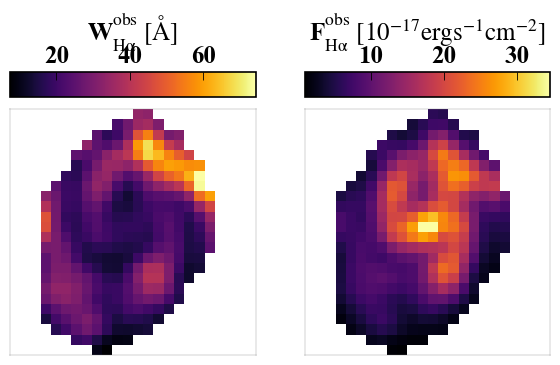

In [22]:
# Plot some maps
psetup(fig_width_pt=textwidth, aspect=1./1.4142, fontsize=18) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
plot_map_manga(ax, 'El_EW_6563', cb_top=True, cmap='inferno')

ax = plt.subplot(gs[0, 1])
plot_map_manga(ax, 'El_F_6563', cb_top=True, cmap='inferno')

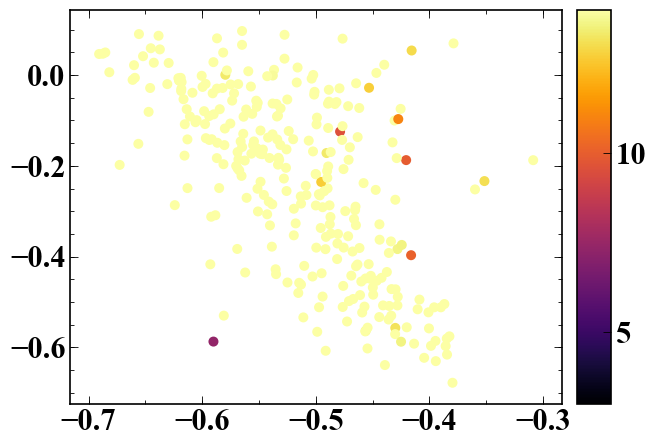

In [23]:
# Plot a classical BPT for the spaxels, colour-coded by EWHa
log_N2Ha = np.log10( ts['El_F_6584'] / ts['El_F_6563'] )
log_O3Hb = np.log10( ts['El_F_5007'] / ts['El_F_4861'] )

psetup(fig_width_pt=textwidth, aspect=1./1.4142, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0, 0])
im = ax.scatter(log_N2Ha, log_O3Hb, c=ts['El_EW_6563'], cmap='inferno', vmin=3, vmax=14)
nplot.fix_ticks(ax)
cb = nplot.tight_colorbar(im)
nplot.fix_colorbar_ticks(cb)
nplot.fix_colorbar_ticks(cb, ny=2)